In [ ]:
#|echo: false
%load_ext autoreload
%autoreload 2

import sys
from fastcore.xtras import Path

In [ ]:
#|echo: false
# Insert in Path Project Directory
sys.path.insert(0, str(Path().cwd().parent))

# RFDataHub 

> A presente biblioteca tem como intuito agregar dados de estações transmissoras de Radiofrequência

* O fluxo é concentrado nos dados licenciados junto à ANATEL de serviços públicos de Radiodifusão e Serviços Privados de Telecomunicações, além de dados de emissores aeronáuticos consumidos de diversas APIs e fontes documentais institucionais.
  
* Os diversos módulos presentes fazem a extração, limpeza, pós-processamento, validação, verificação de qualidade e agregação desses dados num formato consolidado para os planos de monitoração da ANATEL.

<img src="dados.png" width="720"></img>

## BASES DE DADOS
> A Seguir são descritas as instâncias de banco, as bases de dados e as tabelas consultadas.

* Instância de Banco de Dados SQL - Server - `ANATELBDRO05`:
  * Base de Dados: `SITARWEB`:
    * `STEL` - Serviços Privados de Telecomunicações    
    Base legada cujos registros, novos e antigos, estão sendo transferidos para o banco de dados `licenciamento` da instância `ANATELBDRO06` 
  * Base de Dados: `SRD`:
    * `RADCOM` - Serviço de Radiodifusão Comunitária
* Instância de Banco de Dados MongoDB - `ANATELBDRO06`:
  * Base de Dados: `sms`
    * Coleção: `srd`:
      * `SRD` - Demais serviços de Radiodifusão, e.g. TV, RTV, RTVD, FM, AM, etc.
    * Coleção: `licenciamento`:
      * `TELECOM` - Serviços Privados de Telecomunicações, e.g. Limitado Privado.
      * `SMP` - Serviço Móvel Pessoal, e.g. 4G e 5G
  
  > A base de dados `sms`, e no geral a instância como um todo, é referida como `MOSAICO` por conta da plataforma web no qual são servidos esses dados para acesso.
  
* `AERONAUTICA` - Consolidação de diversas bases de dados públicas da aeronáutica. Esses dados são enriquecidos com informações adicionais fornecidas por órgãos como o DECEA, além de emissões conhecidas provenientes de conhecimento técnico prévio consolidado na agência.

In [ ]:
#|echo: false
import pandas as pd
from extracao.constants import MIN_LAT, MAX_LAT, MIN_LONG, MAX_LONG

## RADCOM

In [ ]:
#| code-fold: true
pasta = Path.cwd().parent / 'dados'
df = pd.read_parquet(pasta / 'radcom.parquet.gzip')
df.sample(5).iloc[:, :6]

,Frequência,Entidade,Fistel,Número_Estação,Município,Código_Município
3168,104.9,ASSOCIACAO COMUNITARIA JOAIMENSE CULTURAL DE R...,50012640301,682812145,Joaíma,3136009
3345,104.9,ASSOCIACAO DE AMIGOS VALE DO GUAPORE,50013713175,683836722,Pontes e Lacerda,5106752
4433,105.9,ASSOCIACAO COMUNITARIA DE APOIO A CIDADANIA-ACAC,50013423096,683549529,Guarará,3128501
3169,104.9,ASSOCIAÇÃO COMUNITÁRIA EDUCATIVA DE JURAMENTO ...,50409156329,699282721,Juramento,3136801
457,87.9,ASSOCIAÇÃO COMUNITÁRIA E DE COMUNICAÇÃO SOCIAL...,50409272230,697612040,Salitre,2311959


### Filtragem ✂️

Os únicos filtros efetuados na _query_ para os dados de RADCOM são:
```sql
<...>
where
    SRD.IdtPlanoBasico is not Null 
    and SRD.IndFase is not Null
<...>
``` 
Esse filtro significa que a emissão está licenciada devidamente com o processo de outorga já concluído ou com funcionamento autorizado. 

In [ ]:
#| code-fold: true
print(f'A base RADCOM possui atualmente {len(df)} registros ativos.')

A base RADCOM possui atualmente 4996 registros ativos.


###  Descrição 📊
A seguir são descritas as colunas extraídas da base e o significado de cada uma

* `Frequência`: Frequência de Transmissão da Estação
* `Entidade`: Nome da Pessoa (Física | Jurídica) detentora da Outorga
* `Fistel`: Código itentificador da Outorga de Serviço, um Fistel pode conter uma ou mais estações
* `Número_Estação`: Código Identificador da Estação - Código não necessáriamente único, por vezes uma única estação possui diversos transmissores com características distintas
* `Município`: Município de Outorga daquela estação
* `Código_Município`: Código único do IBGE identificando univocamente o município, esse código é utilizado para validar a localização das coordenadas da estação
* `UF`: Unidade Federativa ( Estado )
* `Latitude`: Latitude em formato Decimal
* `Longitude`: Longitude em formato Decimal
* `Fase`: Fase do Processo de Licenciamento
* `Situação`: Situação da Outorga


### Pós-Processamento 🛠️
A seguir são descritas as colunas adicionadas à base extraída e o significado de cada uma

> As colunas `Fase` e `Situação` somente existem na base `RADCOM`, para normalizar esses dados e combinar com as demais bases, essas duas colunas são transformadas em uma única coluna chamada `Classe`, essa coluna tem o intuito em todas as tabelas de identificar o tipo de estação transmissora:

* Onde a informação de `Situação` é ausente, a `Classe` é igual a `Fase`, exemplos: 
  * `3` 
  * `P`
* Onde ambas estão presentes a `Classe` é igual a `<Fase>-<Situação>`:
  * `3-P` 
  * `P-A` 

* `Num_Serviço`: Número identificador do serviço, no caso de `RADCOM` o valor é único: `231`
* `Classe_Emissão`: Dado ausente na base de `RADCOM` , inserido valores únicos nulos para normalizar com as demais bases
* `Largura_Emissão(kHz)`: Largura de Banda da Emissão em kHz. Nessa coluna é imputado o valor de `256`, valor padrão para o serviço FM.
* `Validade_RF`: Dado ausente na base de `RADCOM` , inserido valores únicos nulos para normalizar com as demais bases
* `Status`: Dado ausente na base de `RADCOM` , inserido valor único `RADCOM` para normalizar com demais bases
* `Fonte`: Fonte dos dados, nessa caso é inserido o nome da Tabela: `SRD`
* `Multiplicidade`: Contagem do Registro. Nesse caso o valor é somente `1` por conta de todos os registros serem únicos, i.e. são referentes a uma estação única

### Dados Incorretos 🗑️
A seguir são exibidas informações sobre coordenadas ausentes ou facilmente identificadas como incorretas, nesse caso fora dos limites do Brasil.
> Uma validação precisa das coordenadas é feita antes de consolidar o arquivo final e será descrita posteriormente

In [ ]:
#|code-fold: True
print(f'Número de coordenadas ausentes: {df[df.Latitude.isna() | df.Longitude.isna()].shape[0]}')

Número de coordenadas ausentes: 0


In [ ]:
#| code-fold: true
df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].astype('float')
bad = df[~(df.Latitude.between(MIN_LAT, MAX_LAT) & df.Longitude.between(MIN_LONG, MAX_LONG))]
print("Exemplo de coordenadas incorretas, fora dos limites do Brasil: ")
bad.loc[:, ['Frequência', 'Entidade', 'Número_Estação', 'Município', 'Latitude', 'Longitude']]

Exemplo de coordenadas incorretas, fora dos limites do Brasil: 


,Frequência,Entidade,Número_Estação,Município,Latitude,Longitude
64,87.5,ASSOCIAÇÃO SERRANA COMUNITÁRIA - ASERCOM,691861544,São Francisco de Paula,-50.572500,-29.446389
327,87.9,Associação de Radiodifusão Comunitária de Ipec...,1010974570,Ipecaetá,-0.205286,-0.655050
470,87.9,ASSOCIAÇÃO COMUNITÁRIA E CULTURAL DE BOA ESPER...,695516850,Boa Esperança,-36.535556,-79.833889
482,87.9,Associação Rural Jaguarense,1015029458,Jaguaré,-0.313650,-0.669211
638,87.9,ASSOCIAÇÃO COMUNITÁRIA DE SÃO LUIZ DO NORTE,695284665,São Luiz do Norte,-36.042222,-68.627222
736,87.9,ASSOCIAÇÃO COMUNITÁRIA VOZ DE SÃO PEDRO DOS CR...,691975078,São Pedro dos Crentes,-3.501111,-0.773333
1072,87.9,ASSOCIAÇÃO DOS AMIGOS DA CULTURA,691081085,Poços de Caldas,-45.838889,-21.923611
1267,87.9,ASSOCIAÇÃO COMUNITÁRIA IPIRANGUENSE,1014626029,Ipiranga do Norte,-0.203989,-0.935672
1330,87.9,FUNDAÇÃO DE ASSISTÊNCIA À FAMÍLIA ANTÔNIO CORR...,695446541,Irituia,-1.771389,-4.437222
1406,87.9,CENTRO INTEGRADO DE AÇÕES COMUNITÁRIAS PELA VIDA,1015253617,João Pessoa,-0.119872,-0.580836


## STEL


In [ ]:
#| code-fold: true
df = pd.read_parquet(pasta / 'stel.parquet.gzip')
df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].astype('float')
df.sample(5).iloc[:, :6]

,Frequência,Entidade,Fistel,Número_Estação,Município,Código_Município
16415,156.675,PETROLEO BRASILEIRO S A PETROBRAS,50411168908,1008756757,Santos,3548500
25728,945.0,UNIVERSIDADE FEDERAL DO PARA,50416059716,1006864110,Acará,1500206
21282,450.4875,RADIO DIFUSORA COLMEIA DE PORTO UNIAO LTDA ME,14020348812,1002823339,União da Vitória,4128203
7963,156.5,HDG SERVICOS AMBIENTAIS LTDA,50405428871,1008115409,São Francisco do Conde,2929206
24272,902.6,UNIVERSIDADE FEDERAL DO PARA,50412323184,1001729843,Belém,1501402


### Filtragem ✂️
> A base do `STEL` de estações outorgadas ativas originalmente era muito grande, comportando milhões de registros, gradualmente os registros ativos e novos registros foram migrados para a base `licenciamento` do `MOSAICO`

A seguir são descritos os filtros realizados na _query_ do `STEL`:

```sql
  <...>
where
  HABILITACAO.NumServico <> '010' #1 
  and ESTACAO.DataExclusao is null #2
  and ESTACAO.IndStatusEstacao = 'L' #3
  and Municipio.CodMunicipio is not null #4
  and frequencia.MedTransmissaoInicial is not null #5 
  and frequencia.CodStatusRegistro = 'L' #6
  and contrato.DataValidadeRadiofrequencia is not null #7
```

Explicando a query acima linha a linha:

1. Excluir estações do Serviço Móvel Pessoal (SMP - 010)
2. Incluir somente estações com `Data de Exclusão` nula, i.e. estações ativas
3. Incluir somente estações com estado  `L` (LICENCIADO)
4. Excluir estações com o código do município ausente (Necessário para validar a localização)
5. Excluir estações sem a frequência de transmissão atribuída 
6. Excluir estações cuja frequência atribuída esteja distinta do estado `L` ( LICENCIADO )
7. Excluir estações cuja Validade de Radiofrequência esteja nula

In [ ]:
#| code-fold: true
print(f'A base STEL possui atualmente {len(df)} registros ativos pelos filtros descritos.')

A base STEL possui atualmente 35417 registros ativos pelos filtros descritos.


###  Descrição 📊
Abaixo são descritas as colunas que não foram descritas anteriormente na base de `RADCOM`

* `Classe`: String que identifica o tipo de estação , e.g `Fixa Aeronáutica`, `Fixa Base`, `Móvel`, `Transmissora` etc...
* `Num_Serviço`: Código que identifica o Serviço Outorgado na Anatel, aqui existem diversos serviços: `604, 035, 507, 019` 
* `Validade_RF`: Data de Validade da Radiofrequência


As demais colunas foram descritas anteriormente para a base `RADCOM`

### Pós-Processamento 🛠️


> Nas tabelas do banco de dados do STEL, na modelagem de banco as informações de `Classe_Emissão` e `Largura_Emissão` foram codificadas numa única string chamada `Designação de Emissão`, é efetuado o processamento dessa string para resgatar as informações individuais em 2 colunas:

* `Classe_Emissão`: Código que identifica as característica da emissão daquela estação
* `Largura_Emissão(kHz)`: Largura de Emissão em kHz
* A coluna  `Validade_RF` é filtrada para constar somente a data, ela aparece no formato `datetime` nas tabelas do banco, no entanto com informação de hora nula
* A `Frequência` é normalizada para a unidade `MHz` 
* `Status`: Essa coluna é criada para normalizar as colunas das bases do `MOSAICO`. É inserido um valor único `L`
* `Fonte`: Fonte dos dados, nessa caso é inserido o nome do Banco `STEL`
* `Multiplicidade`: Contagem do Registro. Nesse caso o valor é somente `1` por conta de todos os registros serem únicos, i.e. são referentes a uma estação única

### Dados Incorretos 🗑️
A seguir são exibidas informações sobre coordenadas ausentes ou facilmente identificadas como incorretas, nesse caso fora dos limites do Brasil.

> Uma validação precisa das coordenadas é feita antes de consolidar o arquivo final e será descrita posteriormente

In [ ]:
#|code-fold: True
print(f'Número de coordenadas ausentes: {df[df.Latitude.isna() | df.Longitude.isna()].shape[0]}')

Número de coordenadas ausentes: 0


In [ ]:
#| code-fold: true
df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].astype('float')
bad = df[~(df.Latitude.between(MIN_LAT, MAX_LAT) & df.Longitude.between(MIN_LONG, MAX_LONG))]
print("Exemplo de coordenadas incorretas, fora dos limites do Brasil: ")
bad.loc[:, ['Frequência', 'Entidade', 'Número_Estação', 'Município', 'Latitude', 'Longitude']]

Exemplo de coordenadas incorretas, fora dos limites do Brasil: 


,Frequência,Entidade,Número_Estação,Município,Latitude,Longitude
1985,131.875,AZUL LINHAS AEREAS BRASILEIRAS S.A,1009302628,Porto Seguro,-16.440833,-30.081389
2874,153.57,RADIO SAO CARLOS LTDA.ME,3570061,São Carlos,-21.033333,-27.966667
2966,153.57,RADIO SAO CARLOS LTDA.ME,3570070,São Carlos,-22.033333,-27.966667
9239,156.525,LOC PILOT PRATICAGEM - EIRELI,1008355728,São Sebastião,-45.467519,-23.817844
9956,156.525,LOC PILOT PRATICAGEM - EIRELI,1008355710,Santos,-46.297125,-23.986986
10487,156.525,LOC PILOT PRATICAGEM - EIRELI,1008355728,São Sebastião,-45.467519,-23.817844
12559,156.5,AMBIPAR RESPONSE S/A,1010754715,Guamaré,-36.390586,-5.148578
13924,156.65,AMBIPAR RESPONSE S/A,1010754715,Guamaré,-36.390586,-5.148578
14702,156.525,LOC PILOT PRATICAGEM - EIRELI,1008355710,Santos,-46.297125,-23.986986
18343,156.8,AMBIPAR RESPONSE S/A,1010754715,Guamaré,-36.390586,-5.148578


## MOSAICO - Radiodifusão

In [ ]:
#| code-fold: true
df = pd.read_parquet(pasta / 'srd.parquet.gzip')
df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].astype('float')
df.sample(5).iloc[:, :6]

,Frequência,Entidade,Fistel,Número_Estação,Município,Código_Município
6157,85.0,PREFEITURA MUNICIPAL DE SEARA,50400688832,323090346,Seara,4217501
23822,593.0,SOCIEDADE RADIO E TELEVISAO ALTEROSA S. A.,50441109144,1013206573,Pitangui,3151404
1588,85.0,PREFEITURA MUNICIPAL DE NOVA VENECIA,50400133296,5591031,Nova Venécia,3203908
16758,97.3,VALE COMUNICAÇÕES LTDA,50401377539,688751997,Diamantino,5103502
8657,479.0,RADIO E TELEVISAO BANDEIRANTES LTDA,50416827802,1007852310,Águas de Lindóia,3500501


### Filtragem ✂️

Os filtros efetuados diretamente no banco MongoDB do Mosaico são simples, a _query_ completa ocupa somente 3 linhas:
```python
{
"frequency": {"$nin": [None, "", 0], "$type": 1.0},
"srd_planobasico.CodMunicipio": {"$nin": [None, ""]},
"NumFistel": {"$nin": [None, ""]},
}
```

* Excluir frequências nulas ou zeradas, e excluir registros não numéricos (`"$type": 1.0` )
* Excluir registros com código de município ausente ou inválido ( Necessário para validar as coordenadas)
* Excluir registros com número do Fistel Nulo ou Inválido


###  Descrição 📊

> 🤌 Não existem informações no MOSAICO de `Classe_Emissão` e tampouco `Largura_de_Emissão` para o serviço de Radiodifusão, assim essas colunas são preenchidas com valores nulos

Adicionalmente são extraídas as seguintes colunas com informações técnicas das estações:

* `Potência(W)`
* `Cod_TipoAntena`
* `Polarização`
* `Raio_Antena`
* `Ganho_Antena`
* `Frente_Costa_Antena`
* `Angulo_Meia_Potencia_Antena`
* `Ângulo_Elevação`
* `Azimute`
* `Altura_Antena`
* `Perdas_Acessorias`

### Pós-Processamento 🛠️


* São mantidas somente estações nos estados autorizados a operar: `C1, C2, C3, C4, C7, C98`
* Normalizada as frequências para a unidade `MHz`
* Imputados os valores para `Largura_de_Emissão(kHz)`, e.g. `256kHz` para o canal estéreo de FM, `6MHz` para TV Digital etc. 

    > Apesar de não constar esses dados na base, os valores de referência são conhecidos pela natureza do Serviço.

In [ ]:
#| code-fold: true
print(f'A base do MOSAICO de Radiodifusão possui atualmente {len(df)} registros ativos pelos filtros descritos.')

A base do MOSAICO de Radiodifusão possui atualmente 31012 registros ativos pelos filtros descritos.


### Dados Incorretos 🗑️
> ☝🏽 Os dados do MOSAICO de Radiodifusão são bastante incompletos em relação às coordenadas, praticamente metade dos registros após a filtragem e pós-processamento não possuem latitude e/ou longitude. No entanto esses dados não são excluídos deliberadamente porque nesses registros serão imputados as coordenadas centrais do município no qual se encontram na etapa de validação de coordenadas. 

In [ ]:
#| code-fold: true
df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].astype('float')
bad = df[~(df.Latitude.between(MIN_LAT, MAX_LAT) & df.Longitude.between(MIN_LONG, MAX_LONG))]
print("Exemplo de coordenadas incorretas ou ausentes: ")
bad.loc[:, ['Frequência', 'Entidade', 'Número_Estação', 'Município', 'Latitude', 'Longitude']]

Exemplo de coordenadas incorretas ou ausentes: 


,Frequência,Entidade,Número_Estação,Município,Latitude,Longitude
0,207.0,REDE DE COMUNICACOES ACREANA LTDA,<NA>,Cruzeiro do Sul,NaN,NaN
1,539.0,X-MEDIAGROUP S.A.,<NA>,Mâncio Lima,NaN,NaN
16,593.0,FUNDACAO EDUCACIONAL E CULTURAL DAS AGUAS QUENTES,<NA>,Caldas Novas,NaN,NaN
17,665.0,GUARANI RADIODIFUSAO LTDA,<NA>,Caldas Novas,NaN,NaN
24,551.0,OCAN COMUNICACAO DIGITAL SE LTDA,1004428283,Santa Quitéria do Maranhão,NaN,NaN
...,...,...,...,...,...,...
31005,581.0,PREFEITURA MUNICIPAL DE APIUNA,<NA>,Apiúna,NaN,NaN
31006,593.0,PREFEITURA MUNICIPAL DE ALVINOPOLIS,<NA>,Alvinópolis,NaN,NaN
31007,635.0,PREFEITURA MUNICIPAL DE SAO TIAGO,<NA>,São Tiago,NaN,NaN
31008,503.0,PREFEITURA MUNICIPAL DE SAO TIAGO,<NA>,São Tiago,NaN,NaN


## MOSAICO - Telecomunicações

In [ ]:
#| code-fold: true
df = pd.read_parquet(pasta / 'telecom.parquet.gzip')
df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].astype('float')
df.sample(5).iloc[:, :6]

,Frequência,Entidade,Fistel,Número_Estação,Município,Código_Município
467215,148.71,TECON RIO GRANDE S/A,50001197975,1014986777,Rio Grande,4315602
561127,245.225,OI S.A. - EM RECUPERAÇÃO JUDICIAL,06030093525,691968292,<NA>,2914307
147545,165.99375,COMPANHIA ESTADUAL DE DISTRIBUICAO DE ENERGIA ...,50405704062,1003279950,,4317301
492247,14.76,CLARO S.A.,50013414186,692458719,Jaboatão dos Guararapes,2607901
146266,383.65,CSP - COMPANHIA SIDERURGICA DO PECEM,50413236749,1003176000,,2312403


### Filtragem ✂️

A _query_ do MongoDB para a base LICENCIAMENTO é listada e descrita a seguir

```python
{"DataExclusao": None},
{"DataValidade": {"$nin": ["", None]}},
{"Status.state": "LIC-LIC-01"},
{"NumServico": {"$nin": ["010", "045", "171", "450", "750", "", None]}},
{"FreqTxMHz": {"$nin": [None, "", 0]}},
{"CodMunicipio": {"$nin": [None, ""]}},
{"FreqTxMHz": {"$type": 1.0}},
{"Latitude": {"$type": 1.0}},
{"Longitude": {"$type": 1.0}}
```

* Registros cuja data de exclusão é Nula, i.e. registros ativos
* Data de Validade de Radiofrequência não nula ou vazia
* Estado `Licenciado`
* Excluir serviços que não são de Radiodfusão ou não são relevantes pelos Planos de Monitoração atualmente, por exemplo `010 - SMP` é extraído separadamente.
* Frequência de Transmissão não nula, zerada ou vazia
* Código de Município não nulo ou vazio
* Frequência de Transmissão no formato numérico (eliminar registros com caracteres e texto)
* Latitude no formato numérico
* Longitude no formato numérico

###  Descrição 📊
> A base do `MOSAICO - licenciamento`, da qual as tabelas de `Telecomunicações` e `Serviço Móvel Pessoal` são extraídas, é de longe a maior atualmente com milhões de registros ativos. As colunas extraídas para os serviços de telecomunicações são as mesmas descritas anteriormente no `MOSAICO - Radiodifusão`. 

### Pós-Processamento 🛠️
> O pós-processamento do MOSAICO - LICENCIAMENTO é mais complexo por conta das escolhas na modelagem do Banco e faz uso extenso de funções da biblioteca `pandas`


* A string `DesignacaoEmissão` é a concatenação das colunas `Largura_Emissão` e `Classe_Emissão` como constavam no STEL. Além do mais existem estações com múltiplas strings de `Emissão` na mesma coluna separadas por vírgula, os passos de processamento dessa colunas são os seguintes:
    * Eliminação de espaços e normalização para maiúscula
    * Expansão dos múltiplos registros separados por vírgula em linhas individuais, 1 por linha com as demais informações idênticas
    * Processamento de cada string `Emissão` concatenada nas duas partes atômicas: `Largura_Emissão` e `Classe_Emissão`

* `Multiplicidade`: Contador do número de estações similares:
    * Existem registros com todas as características anteriores idênticas, exceto o `Número_Estação` por exemplo. 
    * Estações possuem detalhes técnicos que não são considerados relevantes, pelo menos no escopo atual, para a Análise Espectral e Identificação de Emissões - como por exemplo:
        * Tipo de Antena
        * Polarização: Horizontal ou Vertical.
        * Altura da Antena
        * Potência de Transmissão
    
    A seguir é mostrado um exemplo de estação desse tipo, com **201** estações com características técnicas idênticas conforme o quesito descrito no parágrafo anterior:
    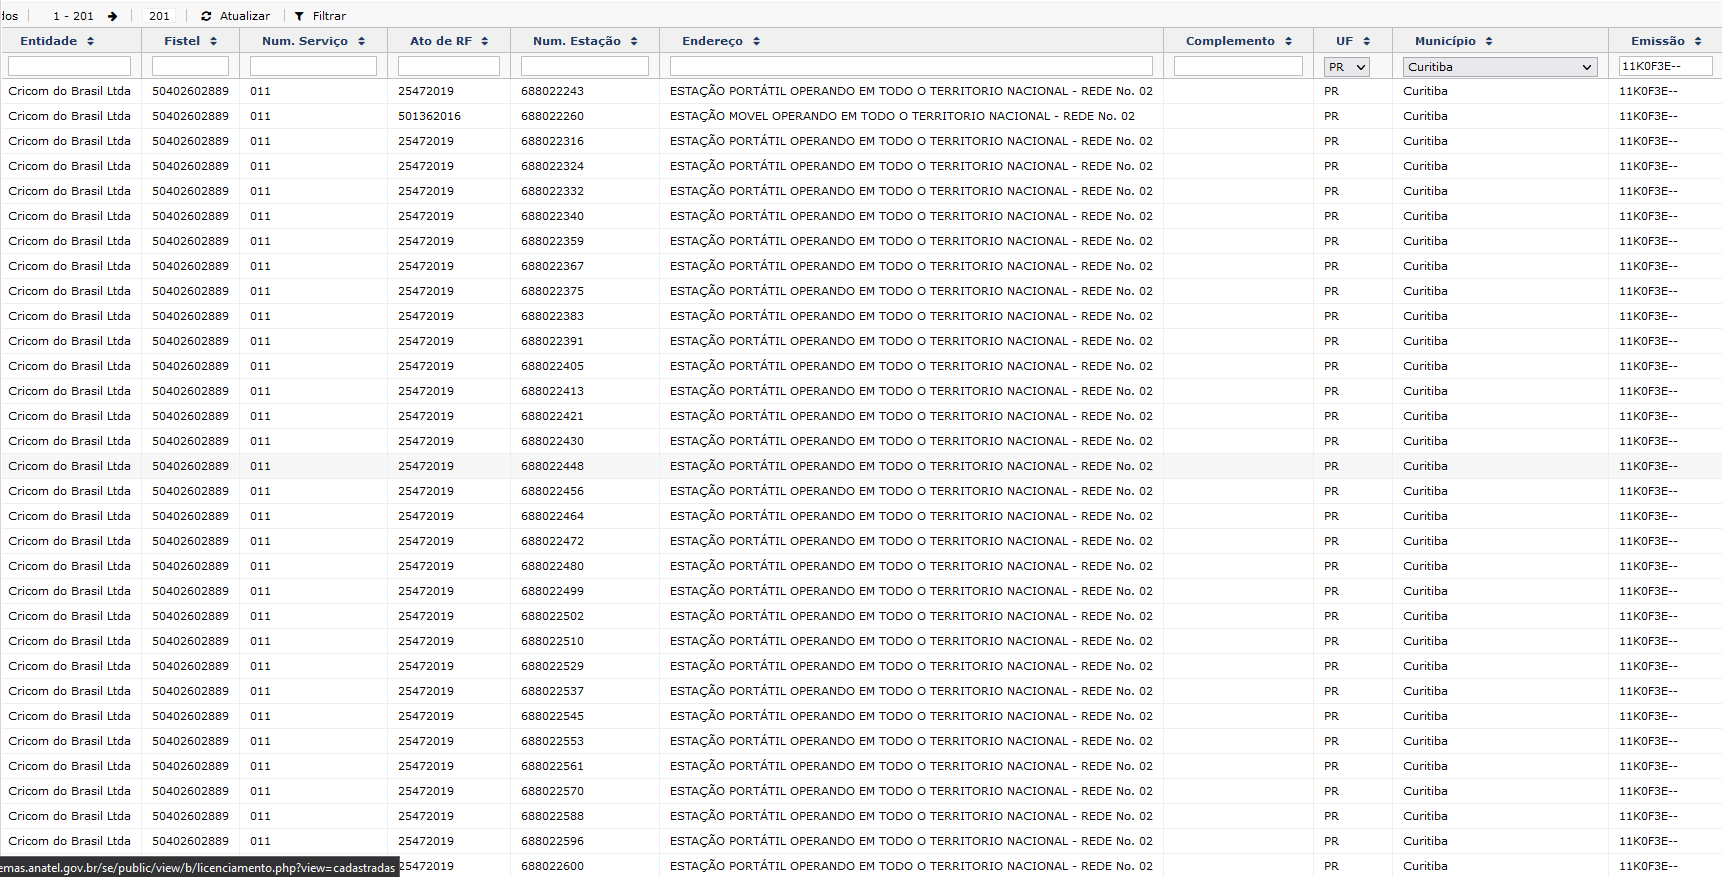

    > Esses registros são considerados idênticos e são agrupados. É utilizado o primeiro número de estação que aparece na base como referência e o total de estações "idênticas" é registrado na coluna multiplicidade: *1 para estações "únicas" e qualquer valor maior que 1 descreve o número de estações similares agrupadas, como as 201 no exemplo anterior*
    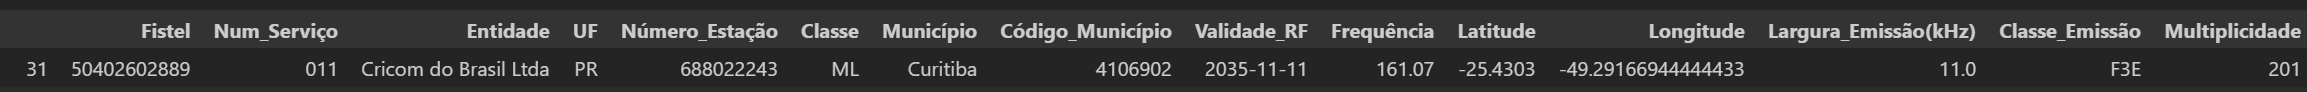

Atualmente esse agrupamento de estações similares em um único registro reduz o número de registro para certa de 10% do original, em outras palavras, no pós-processamento são agregadas cerca de 90% das estações.


In [ ]:
#| code-fold: true
print(f'A base do MOSAICO de Telecomunicações possui atualmente {len(df)} registros ativos pelos filtros descritos.')

A base do MOSAICO de Telecomunicações possui atualmente 757142 registros ativos pelos filtros descritos.


## MOSAICO - Serviço Móvel Pessoal
> Como o serviço de telefonia e banda larga móvel é um serviço de extrema importância e aspecto distinto, com diferentes necessidades de pós-processamento. Esse serviço é extraído num fluxo específico.

In [ ]:
#| code-fold: true
df = pd.read_parquet(pasta / 'smp_formated.parquet.gzip')
df2 = pd.read_parquet(pasta / 'smp_processado.parquet.gzip')
df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].astype('float')
df.sample(5).iloc[:, :6]

,NumAto,DataValidade,NumFistel,NomeEntidade,NumEstacao,Latitude
1853288,110062022.0,2023-04-20,50409146285,TELEFONICA BRASIL S.A.,1010971724,NaN
1926821,29272013,2023-04-30,50409314250,TIM S A,1015051127,NaN
1105173,125002022,2028-11-29,50409314250,TIM S A,688394825,NaN
616063,155832022,2028-11-29,50409146366,TELEFONICA BRASIL S.A.,1000130875,NaN
892766,46622011,2028-03-31,50409105090,CLARO S.A.,641099355,NaN


### Filtragem ✂️
> A query para o serviço SMP, assim como o restante das bases do `MOSAICO` é a mais simples possível, uma vez que filtros e pós-processamento mais sofisticados são feitos diretamente no python utilizando o todo poderoso `pandas` 🐼

```python
MONGO_SMP = {
    "$and": [
        {"DataValidade": {"$nin": ["", None]}},
        {"Status.state": "LIC-LIC-01"},
        {"NumServico": "010"},
        {"FreqTxMHz": {"$nin": [None, "", 0]}},
        {"CodMunicipio": {"$nin": [None, ""]}},
        {"FreqTxMHz": {"$type": 1.0}},
    ]
}
```

* Registros cuja data de exclusão é Nula, i.e. registros ativos
* Estado `Licenciado`
* Extração de estações do serviço SMP - `010`
* Frequência de Transmissão não nula, zerada ou vazia
* Código de Município não nulo ou vazio
* Frequência de Transmissão no formato numérico (eliminar registros com caracteres e texto)

###  Descrição 📊
> As colunas extraídas são as mesmas já descritas anteriormente para as bases de Radiodifusão e Licenciamento.

### Pós-Processamento 🛠️
> O pós-processamento do `MOSAICO - Serviço Móvel Pessoal` envolve mais passos além do que já foi descrito para o `MOSAICO - Licenciamento`. As informações cadastradas são de responsabilidade das entidades, e portanto não há garantia de corretude das informações prestadas. Diversos problemas são encontrados, como dados ausentes e incorretos.

* A string `DesignacaoEmissão` é processada da mesma forma descrita no parágrafo anterior para a base `MOSAICO - Licenciamento`, dela é derivada a coluna `Classe_Emissão` e `Largura_Emissão(kHz)`
* Os registros que possuem a `Frequência_Transmissão` inválida mas não nula ( lembre-se que esses casos já são filtrados pela _query_ efetuada direto no _MongoDB_), tem essa coluna substituída pela `Frequência_Central` caso esta seja válida. Isso é feito para que um registro somente seja descartado quando não for possível fazer nenhum processamento para contornar.
* `Largura_Emissão(kHz)`: Valores nulos são preenchidos com o valor 0
* `Classe_Emissão`: Valores nulos são preenchidos com a string: `NI` ( Não Informado )    

* `Construção da Informação do Canal` 
  > Apesar da informação do canal estar cadastrada nas colunas `Frequência Inicial`, `Frequência Final`, muitos registros estão ausentes ou simplesmente incorretos. Portanto essas informações são descartadas e o canal é derivado à partir da `Frequência_Transmissão` e `Largura_Emissão(kHz)`. 
   * O Início e Fim do Canal são construídos da seguinte forma:
      * `Início_Canal = Frequência_Transmissão - Largura_Emissão`
      * `Fim_Canal = Frequência_Transmissão + Largura_Emissão`
  
* `Multiplicidade` ( Contagem de Estações com as mesmas características )
  > Os responsáveis técnicos pela supervisão dos Planos de Monitoração da Anatel definiram as seguintes colunas como índices para agrupar estações: `['UF', 'Código_Município', 'Fistel', 'Frequência_Transmissão', 'Largura_Emissão(kHz)', 'Classe_Emissão']`
  Em outras palavras, as estações que possuem essas características iguais, são essencialmente idênticas para os fins específicos de detecção no âmbito dos planos de monitoração. 
   1. Qualquer registro com algum desses dados ainda nulos é excluído - não é possível agrupar registro que possua alguma coluna com valor nulo
   2. O seguir os registros são agrupados segundo as colunas supracitadas e a contagem de cada grupo único é registrada na coluna `Multiplicidade`
  
* `Validação dos Canais`
  1. Carregado _arquivo de canalização_ do serviço, previamente construído à partir da  [Resolução nº 757, de 08 de novembro de 2022](https://informacoes.anatel.gov.br/legislacao/resolucoes/2022/1760-resolucao-757)
  2. Para cada registro da base já agregada a canalização é validada da seguinte forma:
     * O canal é cruzado com o _arquivo de canalização_ e checado se o canal está contido num bloco único ou num conjunto de blocos adjacentes dentro de uma das faixas autorizadas. As seguintes informações adicionais são incluídas:
        1. `Canalização`: `Válido | Inválido`  
        2. `Faixa`: Faixa na qual o canal pertence
        3. `Blocos`: Bloco ou Blocos adjacentes que contém o canal
        4. `Offset`: Anotado o `Offset` *Downlink* <-> *Uplink* do bloco ou blocos do Canal
   
          > O registro nesse caso é referente ao *Downlink*, esse valor de `Offset` será usado para definirmos a frequência de *Uplink*

* `Derivação da Frequência de *Uplink*`
  1. Verificação da consistência dos blocos de *Downlink*
   
    > Para cada canal validado pelo, se estiver contido em mais de um bloco, os blocos devem ser adjacentes e possuir somente 1 valor de `Offset` 
  2. Filtrados registros com canalização `Inválido`
  3. Filtrados registros com  `Offset=0` e|ou `Largura_Emissão=0`
    
    > Nesse caso a Frequência de *Uplink* é igual à Frequência de *Downlink* e o registro vale para ambos os casos
  4. Criada Frequência de *Uplink*: `Frequência_Uplink = Frequência_Downlink - Offset`
  5. Concatenado na base os registros derivados de *Uplink*
    
    > Nesse caso são os mesmos dados dos registros válidos de *Downlink* mas com a frequência ( orinalmente de *Downlink* ) substituída pela frequência derivada de *Uplink*

* `Substituição de Coordenadas para os registros agrupados`
  * Para os registros que possuem `Multiplicidade=1`, não houve agregação e a estação é única. Para esses a coordenada da estação é mantida. 
  * Para todos os demais registros as coordenadas são substituídas pela coordenada do município, à partir do `Código_Município` presente no registro.
    
    > Outro tipo de processamento, como imputar uma média das coordenadas por exemplo, não agrega valor "fiscalizatório" porque gera uma coordenada que não existe. A substituição pela coordenada central do município tem o propósito simplesmente de dar a localidade na qual aquele conjunto de estações pertence.

* `Formatação Final`

  * Concatenada a informação sobre a `Tecnologia` na coluna `Classe_Emissão`
  * `Status`: Inserido nessa coluna um valor único `L` para indicar que é licenciada
  * `Fonte`: `MOS` ( MOSAICO ) para o *Downlink* e `DOC` para o *Uplink*
    
    > Esse valor `DOC` vem de Documentação, termo usado genericamente aqui para indicar todos os registros "criados" e não presentes numa base específica, como é o caso aqui dos valores de *Uplink*     
  * `Classe`: Inserido os valores `FB` (Fixa Base) e `ML` (Móvel) para os registros de *Downlink* e *Uplink* respectivamente  

In [ ]:
#| code-fold: true
print(f'A base do MOSAICO - SMP possui atualmente {len(df)} registros extraídos ativos')
print(f'e {len(df2)} registros resultados processados pelos critérios descritos.')

A base do MOSAICO - SMP possui atualmente 1977611 registros extraídos ativos
e 293613 registros resultados processados pelos critérios descritos.


## AERONÁUTICA 🛬

Além de prover uma API que extrai, limpa, processa e padroniza os dados de estações licenciadas na Anatel - relevantes para a Identificação de Emissões no âmbito dos Planos de Monitoração -  Outro diferencial são os dados adicionais de emissões aeronáuticas extraídos e consolidados provenientes de diversas fontes, em sua maioria sem registro "oficial" na Anatel.

As fontes de dados aeronáuticos são:

* ICAO - Através do Software [_Frequency Finder_](https://www.icao.int/safety/FSMP/Documents/Forms/AllItems.aspx?RootFolder=%2fsafety%2ffsmp%2fdocuments%2ffrequencyfinder&FolderCTID=0x012000B1461A5DA8C64241AA4DE4F91CB1D9AF%20%E2%80%8B) são filtradas e exportadas as emissões do Brasil
* [API do AISWEB](https://documenter.getpostman.com/view/7201070/SzKQyg3H)
    * Todos as emissões de Aeródromos Públicos e Militares
* [API do GEOAISWEB](https://geoaisweb.decea.mil.br/)
    * Emissões do tipo `VOR`, `NDB` e `DME`
* [API do REDEMET](https://ajuda.decea.mil.br/base-de-conhecimento/api-redemet-produtos-radar/)
    * Especificamente dados de radares meteorológicos
* Arquivo de Radares
    * Dados adicionais de Radares Secundários nas frequências `1030MHz` e `1090MHz` com frequência e localização conhecida, disponível por documentação interna.
* Arquivo de Canalização
    * Este arquivo, também criado por meio de documentação interna, mapeia os canais das frequências do tipo `VOR_ILSLoc`, nas frequências adicionais `ILS glide`, `DME Airborne` e `DME Ground`. 

    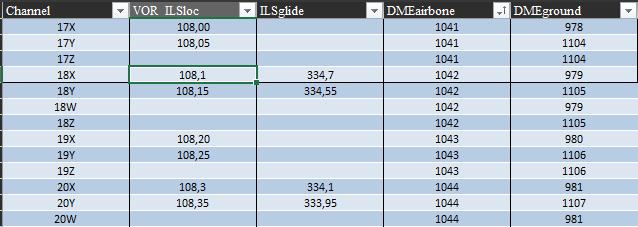

    > Os registros presentes nas bases da aeronáutica, normalmente só contém registros das frequências `VOR_ILSLoc`, no entanto para os canais listados as demais frequências estão presentes e como parte do pós-processamento essas frequências são imputadas mantendo a mesma descrição e localização.

### Pós-Processamento


Não cabe descrever aqui como é implementado o código para consumir as APIs, alguns são um tanto complexos como o AISWEB, para tal basta consultar a documentação ou investigar diretamente os módulos python no entanto o processamento resultante é simples de descrever:

* Mapeamento das frequências `VOR_ILSLoc` no arquivo de canais. As frequências adicionais presentes nos canais são adicionadas no arquivo final.
* Como existe sobreposição de registros, i.e. as bases não são individualizadas, os registros são mapeados entre si e caso estejam a uma distância menor que uma distância de referência ( normalmente uma margem bem ampla de `10Km` ou `20Km`) os registros são mesclados, mantendo-se a coordenada do registro original do `icao` e a descrição de ambos é concatenada.  

In [ ]:
#| code-fold: true
df = pd.read_parquet(pasta / 'aero.parquet.gzip')
for c in ['Latitude', 'Longitude']:
    df[c] = df[c].astype('float')
df.sample(5).iloc[:, :6]

,Frequency,Latitude,Longitude,Description
2874,2800.0,-22.464277,-43.297478,[RMET] Radar - Pico do Couto/RJ
589,1164.0,-9.516666,-35.783333,"[DOC] VOR/DME, MACEIO (Ground-based DME)"
533,115.8,-21.984562,-47.344501,[AISG] VOR - PIRASSUNUNGA CH 105X
2375,131.6,-19.373888,-43.582779,"[ICAO] AOC U 100/100, CONFINS"
842,119.65,-19.373888,-43.582779,"[ICAO] APP-U C-150/450, CONFINS"


## Validação de Coordenadas ✅

In [ ]:
#| code-fold: true
df = pd.read_parquet(pasta / 'base.parquet.gzip')
for c in ['Latitude', 'Longitude']:
    df[c] = df[c].astype('float')
df.sample(5).iloc[:, :6]

,Frequência,Entidade,Fistel,Número_Estação,Município,Código_Município
176758,166.45625,CONCESSIONARIA BR-040 S.A.,50411716298,1000516528,,3146107
788342,458.025,EMPRESA BRASILEIRA DE INFRA-ESTRUTURA AEROPORT...,11030016470,684830337,,1100205
92400,157.45625,AMAZONAS DISTRIBUIDORA DE ENERGIA S/A,50403650801,1002539185,,1302603
477613,407.1,Oi S.a. - em Recuperacao Judicial,04030120318,327632062,<NA>,3127354
739091,149.33,PREFEITURA DO MUNICIPIO DE VALINHOS,50012992097,683172255,,3556206


Vimos superficialmente nos parágrafos anteriores que além haver muitos registros sem coordenadas - como no MOSAICO - SRD - muitas coordenadas não são válidas, seja por inversão de sinal, lugar incorreto do divisor decimal, inversão da Latitude com a Longitude ou simplesmente não correspondem ao município no qual estão licenciadas.

Os passos para validar as informações de localização são:

* Os arquivos descritos anteriormente são concatenados, exceto os dados da aeronáutica por não conter o `Código_Município`
* Os registros com `Código_Município` ausentes são excluídos - este dado é necessário para validar se a coordenadas estão contidas corretamente no município.
* As dados de localização - a saber `Código_Município`, `Latitude`, `Longitude` -  são repassados para uma _query_ SQL que busca na base `CORPORATIVO.dbo.TB_IBGE_MUNICIPIO` e checa **se as coordenadas estão contidas no polígono característico descrito pelo `Código_Município`**, retornando `Verdadeiro` caso positivo e `Falso` caso contrário:

```sql
    SELECT 
        mun.NO_MUNICIPIO 
        , mun.NU_LONGITUDE 
        , mun.NU_LATITUDE         
        , CONVERT(int, 
            (mun.GE_POLIGONO.STIntersects(geometry::STGeomFromText(
                'POINT({} {})', 
                mun.GE_POLIGONO.STSrid)
            )) 
        )AS COORD_VALIDA
    FROM 
        CORPORATIVO.dbo.TB_IBGE_MUNICIPIO mun
    WHERE
        MUN.CO_MUNICIPIO = {}
```
    
* Além disso é retornado o nome padronizado do `Município` e suas coordenadas como registrado oficialmente no IBGE

## Arquivo Final🗄️


O Arquivo final disponibilizado para as atividades de monitoração é formatado da seguinte forma:

* Arquivo base com os dados da Anatel com as seguintes colunas:
    * `Frequência`
    * `Número_Serviço`
    * `Número_Estação`
    * `Classe_Emissão`
    * `Largura_Emissão(kHz)`
* Para simplificação de como os dados são apresentados, é criada a coluna `Descrição` com as seguintes colunas aglutinadas:
    * `Fonte` - _Qual das bases acima é originário o registro_
    * `Status`
    * `Classe`
    * `Entidade`
    * `Fistel`
    * `#Estação` - `Número_Estação`+ `Multiplicidade`
    * `Município_IBGE`
    * `UF`    
    A coluna `Município` é substituída pela coluna `Município_IBGE`, por esta estar completa e validada através do `Código_Município`
    * Os registros que não possuem coordenadas ou estas foram considerados inválidas têm suas coordenadas substituídas pela coordenada do município.
    
        > Para esses registros, é inserido o sinal `*` ao final da `Descrição`.
* Arquivo pós-processado com os dados aeronáuticos
* Mesclagem dos dados aeronáuticos com os registros da Anatel, nos mesmos moldes que os dados aeronáuticos foram mesclados entre si. Nesse caso os dados da Anatel são mantidos e a Descrição da estação aeronáutica concatenada com a Descrição da estação da Anatel.
* Adição de uma coluna numérica identificadora da emissão: `#1, #2, #3, ...` 

In [ ]:
#| code-fold: true
df = pd.read_parquet(pasta / 'AnatelDB.parquet.gzip')
for c in ['Latitude', 'Longitude']:
    df[c] = df[c].astype('float')
df.sample(5)

,Id,Frequency,Latitude,Longitude,Description,Service,Station,Class,BW
237679,#237680,167.81875,-19.867044,-43.925735,"[MOS] L, FX, Policia Militar Do Estado De Mina...",19,1001757839,F1E,8.1
293084,#293085,168.18125,-28.566111,-48.792500,"[MOS] L, FB, Fundo De Melhoria Do Corpo De Bom...",19,1012937884,F1D,7.6
102419,#102420,156.75000,-22.873041,-43.110451,"[STEL] L, FP, Pilot Boat Transportes Maritimos...",604,1007270346,F3E,11.0
385774,#385775,245.47500,-4.163056,-42.013611,"[MOS] L, FX, Telemar Norte Leste S.A. Em Recup...",175,691448892,F3E,16.0
30865,#30866,87.90000,-9.851666,-57.824165,"[SRD] RADCOM, 1-A, Associação Comunitária De N...",231,1015224919,NI,256.0
